# Conv-Net

### Libraries

In [1]:
%matplotlib notebook

import numpy as np # linear algebra
import os
import pickle
import matplotlib.pyplot as plt
import Lung_Segmentation as lung
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

### Dataset

In [2]:
pickle_in = open('F:\Prac_Clinicas\Images\Final_Pickle\Images_0.pickle', 'rb')
Images_0 = np.array(pickle.load(pickle_in))

In [3]:
Images_0.shape

(135, 60, 60, 60)

In [4]:
pickle_in = open('F:\Prac_Clinicas\Images\Final_Pickle\Images_1.pickle', 'rb')
Images_1 = np.array(pickle.load(pickle_in))

In [5]:
Images_1.shape

(868, 60, 60, 60)

### Normalization

In [6]:
from scipy import ndimage

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def process_scan(image):
    """Resize volume"""
    # Normalize
    volume = normalize(image)
    
    return volume

In [7]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(image) for image in Images_0])
normal_scans = np.array([process_scan(image) for image in Images_1])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:95], normal_scans[:608]), axis=0)
y_train = np.concatenate((abnormal_labels[:95], normal_labels[:608]), axis=0)
x_val = np.concatenate((abnormal_scans[95:], normal_scans[608:]), axis=0)
y_val = np.concatenate((abnormal_labels[95:], normal_labels[608:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 703 and 300.


### Plot images

<IPython.core.display.Javascript object>


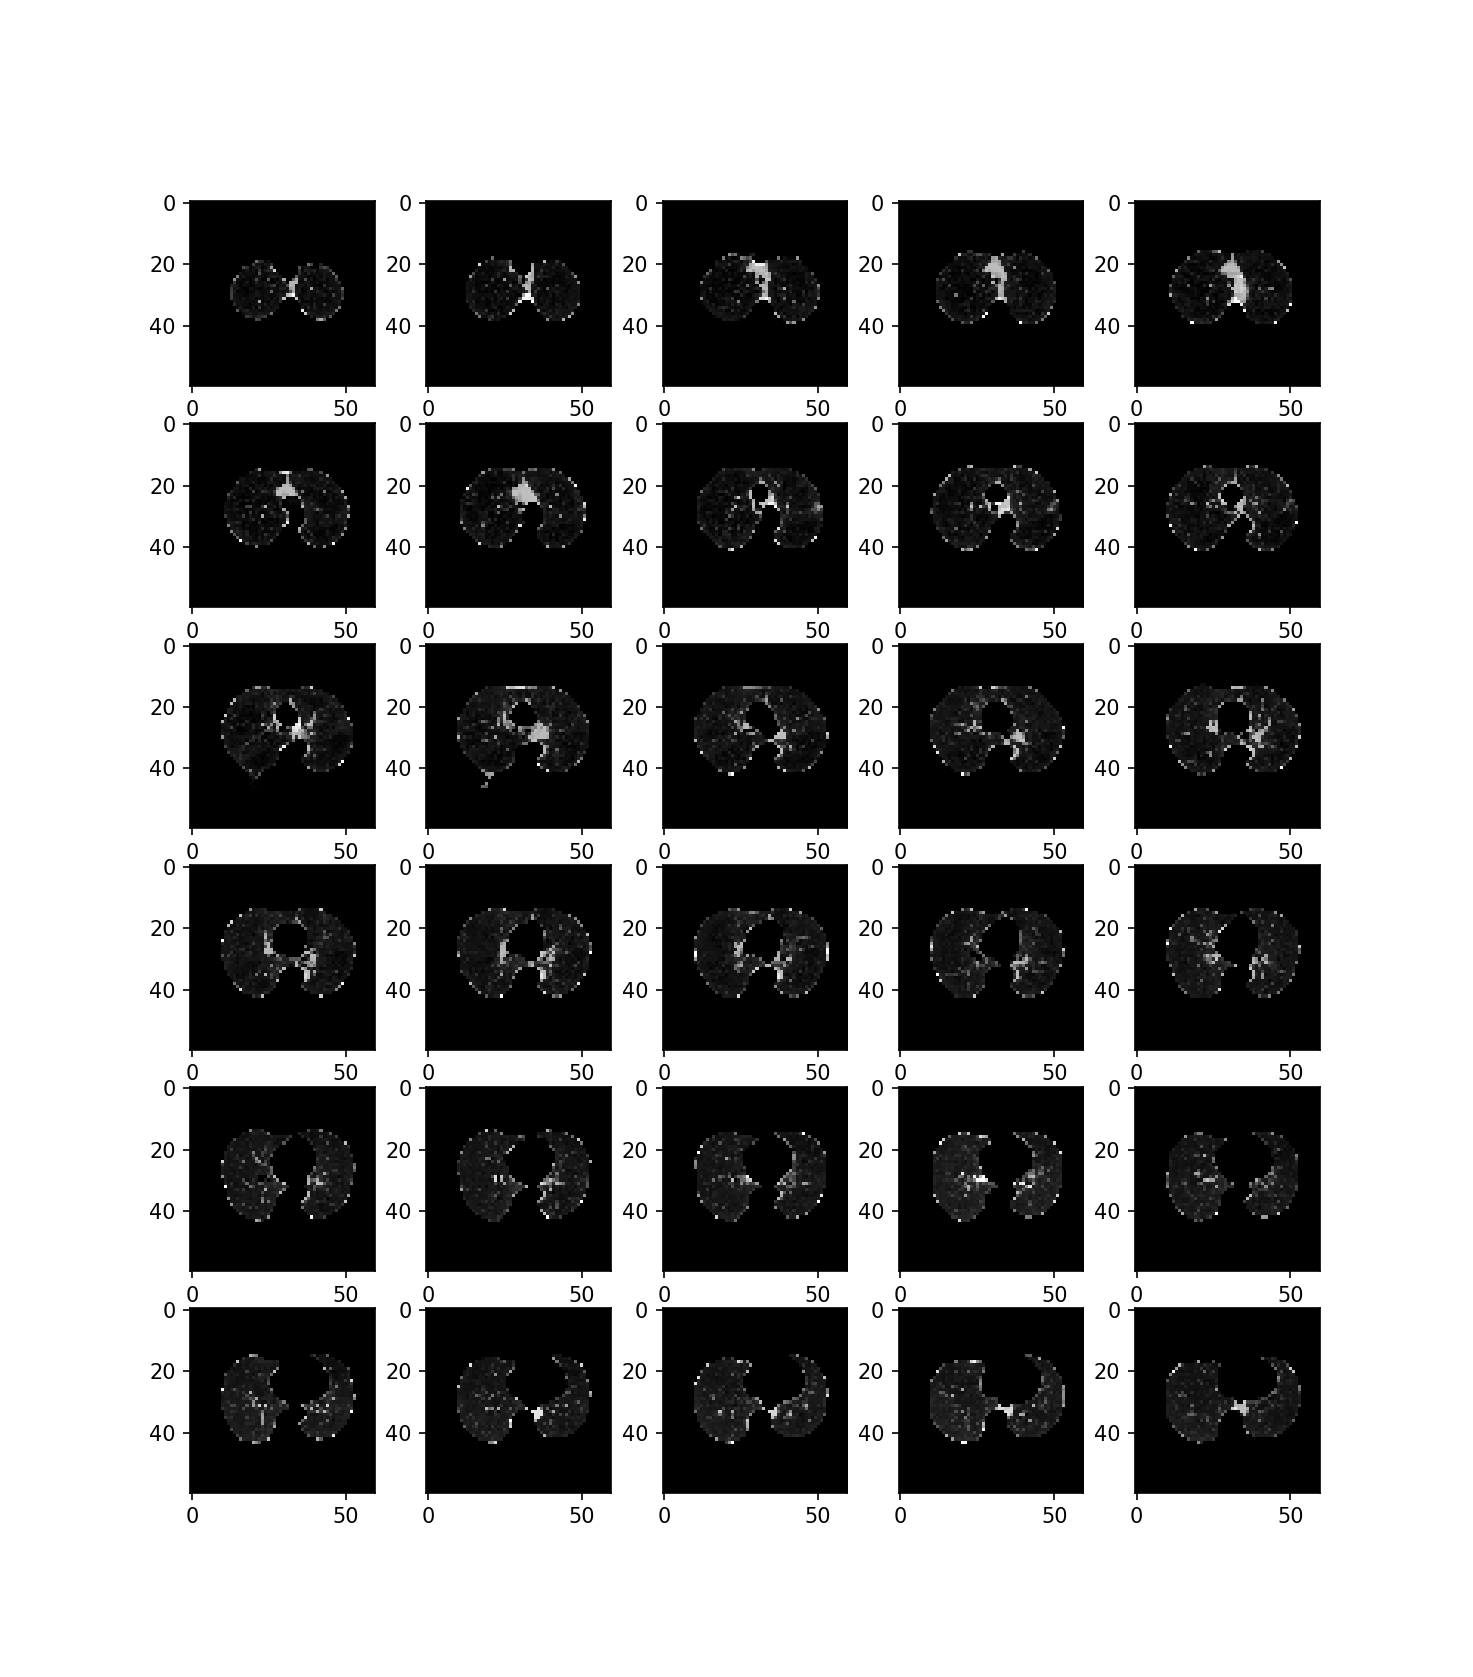

In [45]:
plt.figure()
for i in range(30):
    plt.subplot(6, 5, i+1), plt.imshow(x_train[0][i+10], 'gray')

### Data augmentation

In [9]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

### Model

In [11]:
def get_model(width=60, height=60, depth=60):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=60, height=60, depth=60)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 60, 60, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 58, 58, 58, 64)    1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 29, 29, 29, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 29, 29, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 27, 27, 27, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 13, 13, 13, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 13, 64)    256   

### Train

In [12]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
352/352 - 30s - loss: 0.4494 - acc: 0.8208 - val_loss: 1.1335 - val_acc: 0.8667
Epoch 2/100
352/352 - 26s - loss: 0.4272 - acc: 0.8606 - val_loss: 0.4470 - val_acc: 0.8367
Epoch 3/100
352/352 - 29s - loss: 0.4237 - acc: 0.8592 - val_loss: 0.6171 - val_acc: 0.8667
Epoch 4/100
352/352 - 27s - loss: 0.4103 - acc: 0.8606 - val_loss: 0.7514 - val_acc: 0.8667
Epoch 5/100
352/352 - 25s - loss: 0.4296 - acc: 0.8506 - val_loss: 0.6096 - val_acc: 0.8667
Epoch 6/100
352/352 - 25s - loss: 0.4267 - acc: 0.8606 - val_loss: 0.4824 - val_acc: 0.8667
Epoch 7/100
352/352 - 26s - loss: 0.4197 - acc: 0.8634 - val_loss: 0.5774 - val_acc: 0.8633
Epoch 8/100
352/352 - 25s - loss: 0.4222 - acc: 0.8634 - val_loss: 0.4922 - val_acc: 0.8667
Epoch 9/100
352/352 - 25s - loss: 0.4106 - acc: 0.8563 - val_loss: 0.5083 - val_acc: 0.8667
Epoch 10/100
352/352 - 25s - loss: 0.4284 - acc: 0.8620 - val_loss: 0.5057 - val_acc: 0.8667
Epoch 11/100
352/352 - 25s - loss: 0.4143 - acc: 0.8620 - val_loss: 0.4203 - va

### Visualizing model performance

<IPython.core.display.Javascript object>


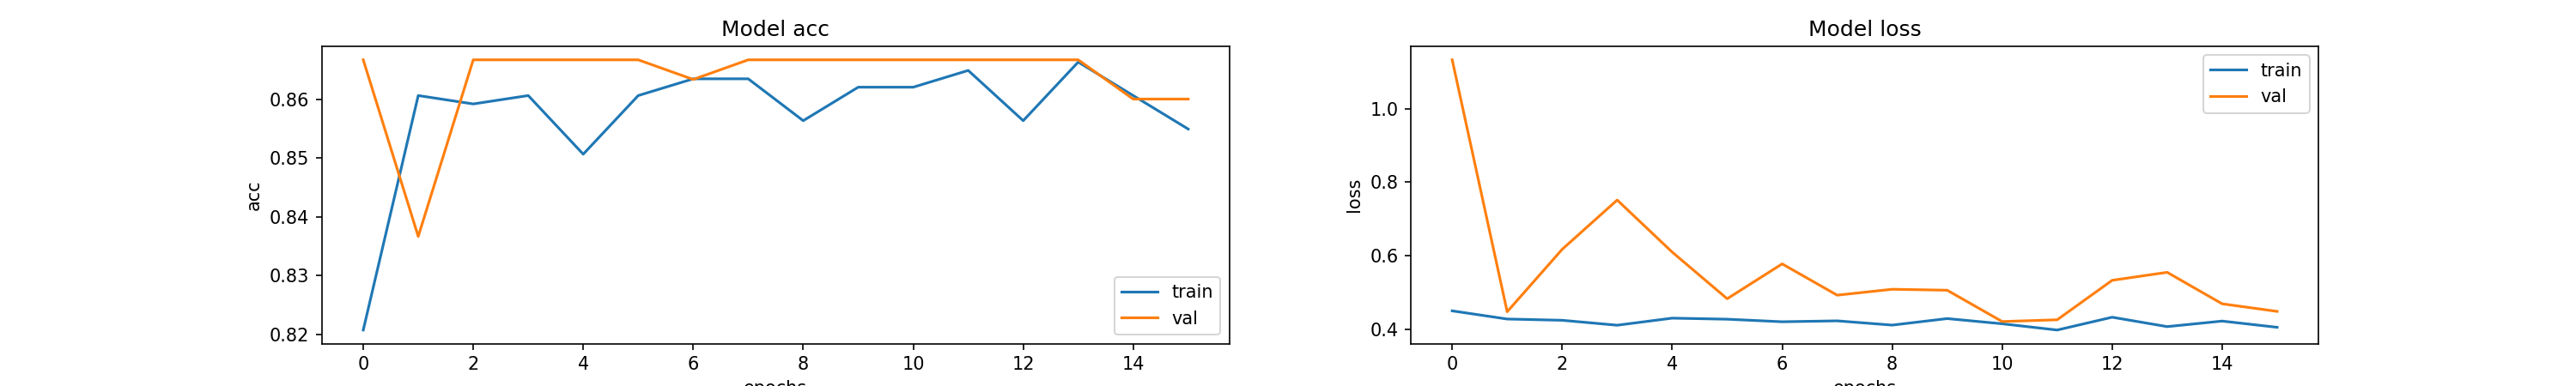

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Make predictions on a single CT scan

In [14]:
df = pd.read_excel('F:/Prac_Clinicas/LIDC-IDRI/Nodules_DF_1012.xlsx', index_col=0)

##### Predictions on Group 0

In [22]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
print('Model confidence for each image. There are {} images.\n\nSmaller than 3 mm or none (Group 0)\nBigger than 3 mm (Group 1)'.format(len(abnormal_scans)))

Group_0_0s = []
Group_0_1s = []

for i in range(len(abnormal_scans)):
    prediction = model.predict(np.expand_dims(abnormal_scans[i], axis=0))[0]
    scores = [prediction[0], 1-prediction[0]]
    Group_0_0s.append(100 * scores[0])
    Group_0_1s.append(100 * scores[1])
    class_names = ["\n0)", "1)"]
    for score, name in zip(scores, class_names):
        print(
            "%s: %.2f "
            % (name, (100 * score))
        )

Model confidence for each image. There are 135 images.

Smaller than 3 mm or none (Group 0)
Bigger than 3 mm (Group 1)

0): 2.03 
1): 97.97 

0): 0.09 
1): 99.91 

0): 0.49 
1): 99.51 

0): 0.66 
1): 99.34 

0): 0.12 
1): 99.88 

0): 3.27 
1): 96.73 

0): 1.61 
1): 98.39 

0): 0.24 
1): 99.76 

0): 4.28 
1): 95.72 

0): 23.35 
1): 76.65 

0): 0.95 
1): 99.05 

0): 1.10 
1): 98.90 

0): 2.20 
1): 97.80 

0): 14.65 
1): 85.35 

0): 4.88 
1): 95.12 

0): 1.47 
1): 98.53 

0): 15.10 
1): 84.90 

0): 2.78 
1): 97.22 

0): 0.22 
1): 99.78 

0): 0.25 
1): 99.75 

0): 17.03 
1): 82.97 

0): 19.27 
1): 80.73 

0): 17.78 
1): 82.22 

0): 5.40 
1): 94.60 

0): 10.83 
1): 89.17 

0): 5.35 
1): 94.65 

0): 8.32 
1): 91.68 

0): 7.80 
1): 92.20 

0): 4.96 
1): 95.04 

0): 7.41 
1): 92.59 

0): 4.17 
1): 95.83 

0): 6.52 
1): 93.48 

0): 20.10 
1): 79.90 

0): 13.95 
1): 86.05 

0): 3.08 
1): 96.92 

0): 0.44 
1): 99.56 

0): 17.97 
1): 82.03 

0): 1.51 
1): 98.49 

0): 28.43 
1): 71.57 

0): 10.70 


In [ ]:
df.loc[df['Nodules'] == 0]

##### Predictions on Group 1

In [28]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
print('Model confidence for each image. There are {} images.\n\nSmaller than 3 mm or none (Group 0)\nBigger than 3 mm (Group 1)'.format(len(normal_scans)))
Group_1_0s = []
Group_1_1s = []
for i in range(len(normal_scans)):
    prediction = model.predict(np.expand_dims(normal_scans[i], axis=0))[0]
    scores = [prediction[0], 1-prediction[0]]
    Group_1_0s.append(100 * scores[0])
    Group_1_1s.append(100 * scores[1])
    class_names = ["\n0)", "1)"]
    for score, name in zip(scores, class_names):
        print(
            "%s: %.2f "
            % (name, (100 * score))
        )

Model confidence for each image. There are 868 images.

Smaller than 3 mm or none (Group 0)
Bigger than 3 mm (Group 1)

0): 0.67 
1): 99.33 

0): 6.69 
1): 93.31 

0): 0.77 
1): 99.23 

0): 0.79 
1): 99.21 

0): 6.23 
1): 93.77 

0): 0.33 
1): 99.67 

0): 0.00 
1): 100.00 

0): 0.26 
1): 99.74 

0): 0.09 
1): 99.91 

0): 0.82 
1): 99.18 

0): 11.45 
1): 88.55 

0): 3.35 
1): 96.65 

0): 0.35 
1): 99.65 

0): 0.12 
1): 99.88 

0): 0.48 
1): 99.52 

0): 0.05 
1): 99.95 

0): 3.19 
1): 96.81 

0): 16.12 
1): 83.88 

0): 0.68 
1): 99.32 

0): 0.16 
1): 99.84 

0): 0.53 
1): 99.47 

0): 2.51 
1): 97.49 

0): 3.14 
1): 96.86 

0): 4.23 
1): 95.77 

0): 0.43 
1): 99.57 

0): 1.80 
1): 98.20 

0): 9.13 
1): 90.87 

0): 0.38 
1): 99.62 

0): 0.15 
1): 99.85 

0): 2.80 
1): 97.20 

0): 1.89 
1): 98.11 

0): 14.97 
1): 85.03 

0): 5.21 
1): 94.79 

0): 18.65 
1): 81.35 

0): 0.21 
1): 99.79 

0): 2.03 
1): 97.97 

0): 1.32 
1): 98.68 

0): 1.76 
1): 98.24 

0): 1.81 
1): 98.19 

0): 7.45 
1): 92.


0): 14.31 
1): 85.69 

0): 1.77 
1): 98.23 

0): 36.84 
1): 63.16 

0): 4.35 
1): 95.65 

0): 0.42 
1): 99.58 

0): 11.45 
1): 88.55 

0): 0.14 
1): 99.86 

0): 31.51 
1): 68.49 

0): 1.65 
1): 98.35 

0): 1.71 
1): 98.29 

0): 0.42 
1): 99.58 

0): 5.49 
1): 94.51 

0): 2.01 
1): 97.99 

0): 36.00 
1): 64.00 

0): 1.70 
1): 98.30 

0): 5.91 
1): 94.09 

0): 0.03 
1): 99.97 

0): 11.48 
1): 88.52 

0): 12.06 
1): 87.94 

0): 14.62 
1): 85.38 

0): 12.19 
1): 87.81 

0): 14.25 
1): 85.75 

0): 0.21 
1): 99.79 

0): 0.61 
1): 99.39 

0): 31.58 
1): 68.42 

0): 2.73 
1): 97.27 

0): 10.96 
1): 89.04 

0): 19.96 
1): 80.04 

0): 2.58 
1): 97.42 

0): 16.73 
1): 83.27 

0): 22.79 
1): 77.21 

0): 7.11 
1): 92.89 

0): 0.04 
1): 99.96 

0): 9.99 
1): 90.01 

0): 20.40 
1): 79.60 

0): 7.10 
1): 92.90 

0): 9.46 
1): 90.54 

0): 13.24 
1): 86.76 

0): 1.87 
1): 98.13 

0): 18.88 
1): 81.12 

0): 18.83 
1): 81.17 

0): 29.29 
1): 70.71 

0): 5.54 
1): 94.46 

0): 0.12 
1): 99.88 

0): 1.17 
1


0): 3.99 
1): 96.01 

0): 16.74 
1): 83.26 

0): 13.26 
1): 86.74 

0): 30.51 
1): 69.49 

0): 0.01 
1): 99.99 

0): 3.77 
1): 96.23 

0): 2.94 
1): 97.06 

0): 17.39 
1): 82.61 

0): 33.07 
1): 66.93 

0): 11.05 
1): 88.95 

0): 1.91 
1): 98.09 

0): 12.70 
1): 87.30 

0): 5.37 
1): 94.63 

0): 1.79 
1): 98.21 

0): 32.17 
1): 67.83 

0): 25.34 
1): 74.66 

0): 13.82 
1): 86.18 

0): 0.21 
1): 99.79 

0): 15.32 
1): 84.68 

0): 8.29 
1): 91.71 

0): 3.24 
1): 96.76 

0): 2.08 
1): 97.92 

0): 4.99 
1): 95.01 

0): 15.13 
1): 84.87 

0): 6.78 
1): 93.22 

0): 38.47 
1): 61.53 

0): 10.64 
1): 89.36 

0): 1.48 
1): 98.52 

0): 0.38 
1): 99.62 

0): 12.41 
1): 87.59 

0): 1.42 
1): 98.58 

0): 9.56 
1): 90.44 

0): 26.01 
1): 73.99 

0): 1.71 
1): 98.29 

0): 2.17 
1): 97.83 

0): 0.12 
1): 99.88 

0): 10.89 
1): 89.11 

0): 0.72 
1): 99.28 

0): 3.46 
1): 96.54 

0): 1.14 
1): 98.86 

0): 10.62 
1): 89.38 

0): 2.26 
1): 97.74 

0): 2.37 
1): 97.63 

0): 12.85 
1): 87.15 

0): 2.77 
1)

In [17]:
df.loc[df['Nodules'] == 1]

,Number,Nodules
TCIA Patent ID,,
LIDC-IDRI-0001,1,1.0
LIDC-IDRI-0002,1,1.0
LIDC-IDRI-0003,4,1.0
LIDC-IDRI-0004,1,1.0
LIDC-IDRI-0005,3,1.0
...,...,...
LIDC-IDRI-1008,6,1.0
LIDC-IDRI-1009,1,1.0
LIDC-IDRI-1010,1,1.0
